In [1]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%env KMP_DUPLICATE_LIB_OK=TRUE # fixed my kernel dead

env: KMP_DUPLICATE_LIB_OK=TRUE # fixed my kernel dead


# Data 

In [4]:
words = open("names.txt", 'r').read().split()

In [54]:
# characters mapping to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build data set with mini batch
random.seed(49)
random.shuffle(words)

block_size = 3 # context length: how many previous characters do we take to predict the next char?
X, y = [], []

for w in words:
    context = [0] * block_size
    chrs = list(w) + ['.']
    for ch in chrs:
        ix = stoi[ch]
        X.append(context)
        y.append(ix)
        # print(  ''.join(itos[i] for i in context) + '--->' + itos[ix] )
        context = context[1:] + [ix]

X = torch.tensor(X)
y = torch.tensor(y)

n1 = int(len(X)*0.8)
n2 = int(len(X)*0.9)

X_train, y_train = X[:n1], y[:n1]
X_val, y_val = X[n1:n2], y[n1:n2]
X_test, y_test = X[n2:], y[n2:]

In [7]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([182516, 3]) torch.Size([182516])
torch.Size([22815, 3]) torch.Size([22815])
torch.Size([22815, 3]) torch.Size([22815])


# Original initialization

In [168]:
dims_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(49)

C = torch.randn(vocab_size, dims_embd, generator=g)
w1 = torch.randn((dims_embd*block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden, generator=g) 
w2 = torch.randn((n_hidden, vocab_size), generator=g) 
b2 = torch.randn(vocab_size, generator=g) 
parameters = [C, w1, b1, w2, b2]

In [169]:
num_params = sum(p.nelement() for p in parameters)
print(f"total parameters: {num_params}")

# set gradient tracking 
for p in parameters:
    p.requires_grad = True

total parameters: 11897


In [170]:
epochs = 20000
batch_size = 32
loss_i = []
lr = 1e-1

In [171]:
for i in range(epochs+1):
    # mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))

    # forward pass
    emb = C[X_train[ix]]
    embcat = emb.view(-1, dims_embd*block_size)
    h_pre_act = embcat @ w1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    #backward pass
    for p in parameters:
        p.grad = None # set zero grad

    loss.backward() # backward 
    
    if i >= 10000: lr = 1e-2 # learning late decay
    for p in parameters:
        p.data += -lr * p.grad # update step
        
    # track stats
    loss_i.append(loss.item())
    
    if i % 1000 == 0:
        print(f'{i}/{epochs}: {loss.item():.4f}') 
        
    break

0/20000: 31.0364


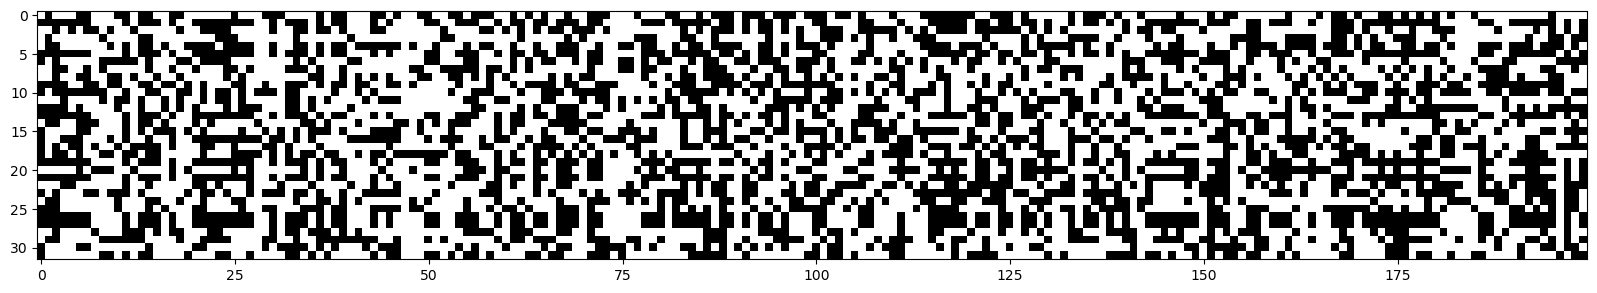

In [179]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray');

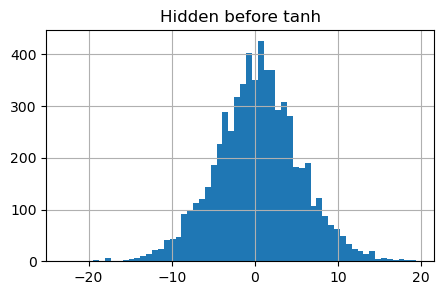

In [147]:
plt.figure(figsize=(5,3))
plt.hist(h_pre_act.ravel().tolist(), 60);
plt.title('Hidden before tanh')
plt.grid();

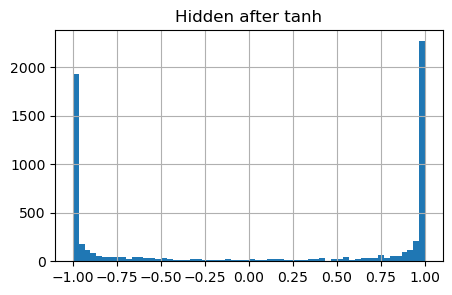

In [144]:
plt.figure(figsize=(5,3))
plt.hist(h.ravel().tolist(), 60);
plt.title('Hidden after tanh')
plt.grid();

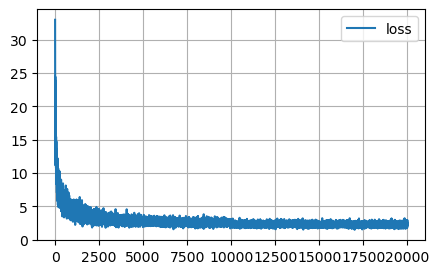

In [153]:
plt.figure(figsize=(5,3))
plt.plot(loss_i)
plt.legend(['loss'])
plt.grid();

In [155]:
# Validation
emb = C[X_val]
h = torch.tanh(emb.view(-1, dims_embd*block_size) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.3065, grad_fn=<NllLossBackward0>)

# Hacky initialization

In [206]:
dims_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(49)

C = torch.randn(vocab_size, dims_embd, generator=g)
w1 = torch.randn((dims_embd*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.0
parameters = [C, w1, b1, w2, b2]

In [207]:
num_params = sum(p.nelement() for p in parameters)
print(f"total parameters: {num_params}")

# set gradient tracking 
for p in parameters:
    p.requires_grad = True

total parameters: 11897


In [208]:
epochs = 20000
batch_size = 32
loss_i = []
lr = 1e-1

In [209]:
for i in range(epochs+1):
    # mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))

    # forward pass
    emb = C[X_train[ix]]
    embcat = emb.view(-1, dims_embd*block_size)
    h_pre_act = embcat @ w1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    #backward pass
    for p in parameters:
        p.grad = None # set zero grad

    loss.backward() # backward 
    
    if i >= 10000: lr = 1e-2 # learning late decay
    for p in parameters:
        p.data += -lr * p.grad # update step
        
    # track stats
    loss_i.append(loss.item())
    
    if i % 1000 == 0:
        print(f'{i}/{epochs}: {loss.item():.4f}') 

    break

0/20000: 3.3126


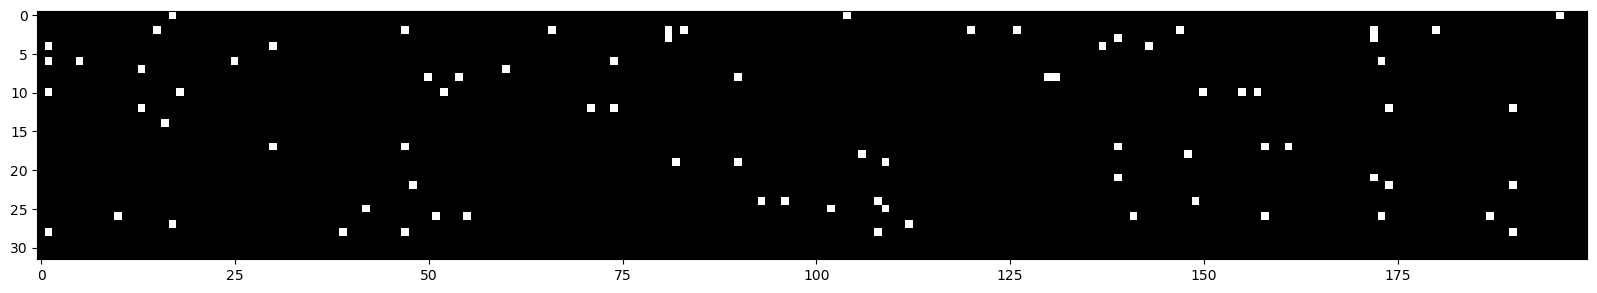

In [210]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray');

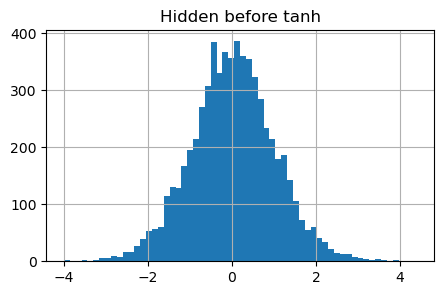

In [211]:
plt.figure(figsize=(5,3))
plt.hist(h_pre_act.ravel().tolist(), 60);
plt.title('Hidden before tanh')
plt.grid();

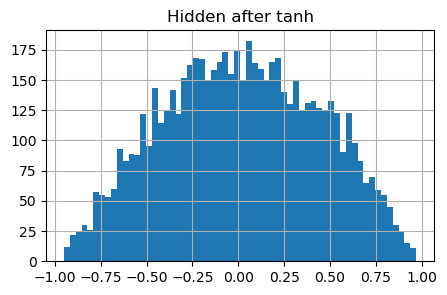

In [167]:
plt.figure(figsize=(5,3))
plt.hist(h.ravel().tolist(), 60);
plt.title('Hidden after tanh')
plt.grid();

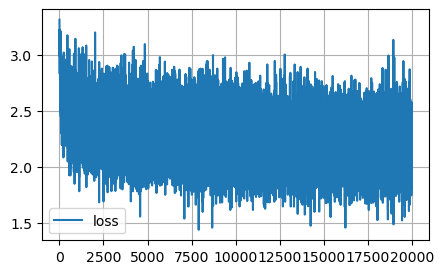

In [160]:
plt.figure(figsize=(5,3))
plt.plot(loss_i)
plt.legend(['loss'])
plt.grid();

In [161]:
# Validation
emb = C[X_val]
h = torch.tanh(emb.view(-1, dims_embd*block_size) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.2065, grad_fn=<NllLossBackward0>)

# Kaiming Initialization
1/sqrt(fan_in)

In [228]:
dims_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(49)

C = torch.randn(vocab_size, dims_embd, generator=g)
w1 = torch.randn((dims_embd*block_size, n_hidden), generator=g) * 1/((dims_embd*block_size)**0.5) # (5/3)
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.0
parameters = [C, w1, b1, w2, b2]

In [229]:
num_params = sum(p.nelement() for p in parameters)
print(f"total parameters: {num_params}")

# set gradient tracking 
for p in parameters:
    p.requires_grad = True

total parameters: 11897


In [230]:
epochs = 20000
batch_size = 32
loss_i = []
lr = 1e-1

In [231]:
for i in range(epochs+1):
    # mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))

    # forward pass
    emb = C[X_train[ix]]
    embcat = emb.view(-1, dims_embd*block_size)
    h_pre_act = embcat @ w1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    #backward pass
    for p in parameters:
        p.grad = None # set zero grad

    loss.backward() # backward 
    
    if i >= 10000: lr = 1e-2 # learning late decay
    for p in parameters:
        p.data += -lr * p.grad # update step
        
    # track stats
    loss_i.append(loss.item())
    
    if i % 1000 == 0:
        print(f'{i}/{epochs}: {loss.item():.4f}') 

0/20000: 3.3112
1000/20000: 2.5331
2000/20000: 2.2696
3000/20000: 2.1464
4000/20000: 2.1004
5000/20000: 2.3465
6000/20000: 2.4033
7000/20000: 2.7154
8000/20000: 2.1432
9000/20000: 2.3419
10000/20000: 2.3324
11000/20000: 2.1712
12000/20000: 1.7289
13000/20000: 2.0435
14000/20000: 1.9243
15000/20000: 1.9997
16000/20000: 2.2523
17000/20000: 2.4877
18000/20000: 2.1911
19000/20000: 2.2453
20000/20000: 2.1593


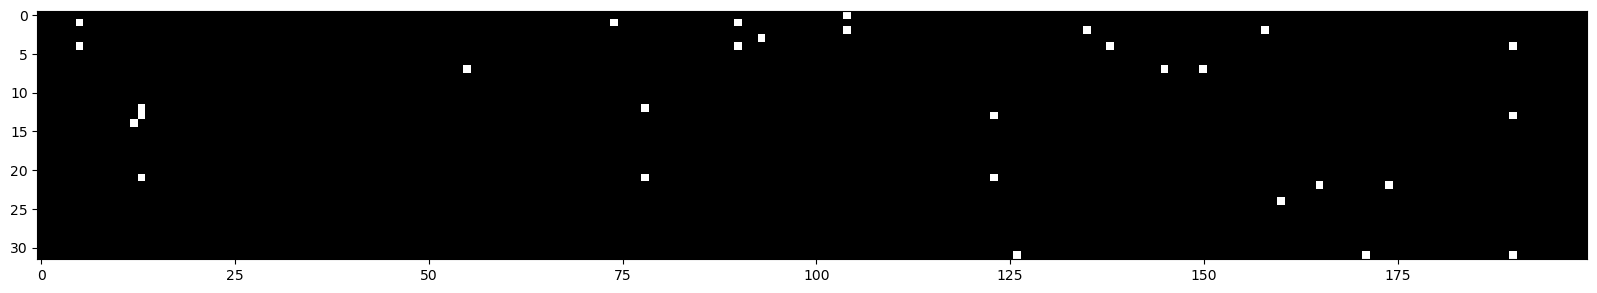

In [224]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray');

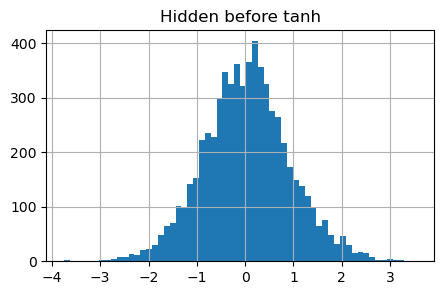

In [225]:
plt.figure(figsize=(5,3))
plt.hist(h_pre_act.ravel().tolist(), 60);
plt.title('Hidden before tanh')
plt.grid();

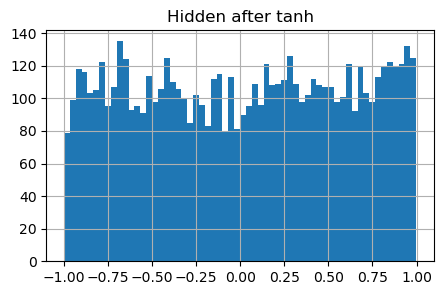

In [226]:
plt.figure(figsize=(5,3))
plt.hist(h.ravel().tolist(), 60);
plt.title('Hidden after tanh')
plt.grid();

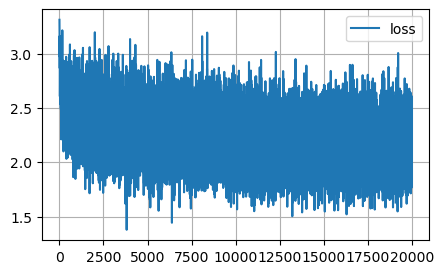

In [232]:
plt.figure(figsize=(5,3))
plt.plot(loss_i)
plt.legend(['loss'])
plt.grid();

In [233]:
# Validation
emb = C[X_val]
h = torch.tanh(emb.view(-1, dims_embd*block_size) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.1836, grad_fn=<NllLossBackward0>)